In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import pandas as pd

from tools import *

In [14]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

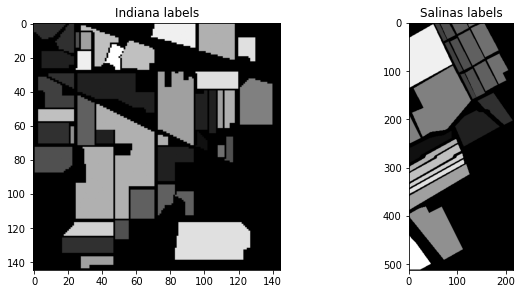

In [15]:
plot_two_figures(indiana_labels, salinas_labels, "Indiana labels", "Salinas labels")

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
def get_number_components(X):
    # first PCA with by keeping all features
    print("Fitting the PCA")
    pca_model = PCA()
    pca_model.fit(X)
    var_cumsum = pca_model.explained_variance_ratio_.cumsum()
    return len(var_cumsum[var_cumsum <= 0.9991])

def extract_features(X, n_components):
    pca_model = PCA(n_components=n_components)
    pca_model.fit(X)
    return pca_model.transform(X)

In [7]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [8]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [9]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, 20)

In [10]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 20)


In [11]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [ ]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [16]:
model = SpectralBiclustering(n_clusters=n_cluster_indiana)

In [17]:
model.fit(X_indiana_reduced)

SpectralBiclustering(n_clusters=16)

In [18]:
model.row_labels_.shape

(21025,)

In [19]:
model.column_labels_.shape

(69,)

In [20]:
preds = model.row_labels_
preds = preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))
preds.shape

(145, 145)

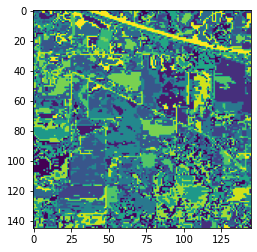

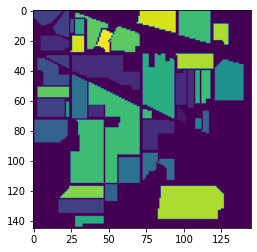

In [21]:
plt.imshow(preds)
plt.show()
plt.imshow(indiana_labels)
plt.show()

In [22]:
def remove_unclassified(preds, labels):
    preds_cpy = preds.copy()
    zeros_idx = np.argwhere(labels.flatten() == 0).flatten()
    preds_cpy += 1
    preds_flatten = preds_cpy.flatten()
    preds_flatten[zeros_idx] = 0
    final_preds = preds_flatten.reshape((preds.shape[0], preds.shape[1]))
    return final_preds 

In [23]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

In [24]:
confusion_mat = confusion_matrix(indiana_labels.flatten(), final_preds.flatten())

NameError: name 'final_preds' is not defined

In [ ]:
np.unique(indiana_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

In [ ]:
confusion_mat = confusion_mat[1:, 1:]

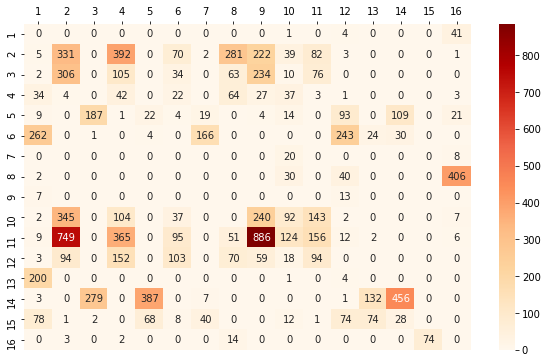

In [ ]:
import seaborn as sn
from matplotlib.colors import LogNorm

classe_names = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 16]

matrix = confusion_matrix(indiana_labels.flatten(), final_preds.flatten())
matrix = matrix[1:, 1:]
df = pd.DataFrame({classe_names[i]:matrix[:,i] for i in range(16)}, index=classe_names)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
ax.xaxis.set_ticks_position('top')
sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

plt.show() 

In [ ]:
model_salinas = SpectralBiclustering(n_clusters=n_cluster_salinas)

In [ ]:
model_salinas.fit(X_salinas_reduced)

SpectralBiclustering(init='k-means++', method='bistochastic', mini_batch=False,
                     n_best=3, n_clusters=16, n_components=6, n_init=10,
                     n_jobs=None, n_svd_vecs=None, random_state=None,
                     svd_method='randomized')

In [ ]:
preds_salinas = model_salinas.row_labels_.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [ ]:
final_preds = remove_unclassified(preds_salinas, salinas_labels)

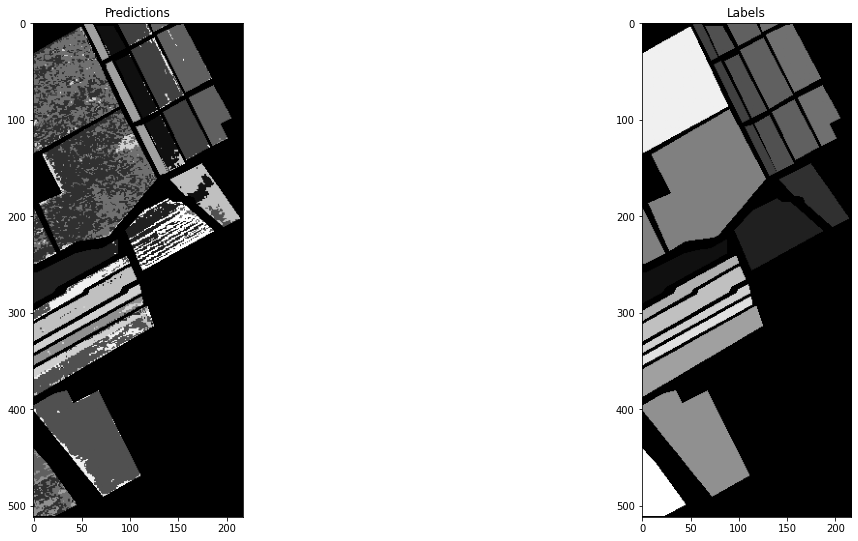

In [ ]:
def plot_two_figures(fig1, fig2, title_fig1, title_fig2, figsize=(10, 10)):
    plt.figure(figsize=figsize)

    plt.subplot(2, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title_fig1)

    plt.subplot(2, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title_fig2)

    plt.show() 

plot_two_figures(final_preds, salinas_labels, 'Predictions', 'Labels', figsize=(20, 20))

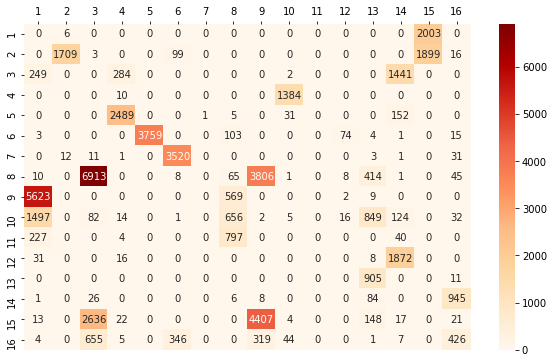

In [ ]:
classe_names = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 16]

matrix = confusion_matrix(salinas_labels.flatten(), final_preds.flatten())
matrix = matrix[1:, 1:]
df = pd.DataFrame({classe_names[i]:matrix[:,i] for i in range(16)}, index=classe_names)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
ax.xaxis.set_ticks_position('top')
sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

plt.show() 

In [ ]:
l2, c2 = np.unique(salinas_labels, return_counts=True)
l2 = c2.argsort()


In [ ]:
l, c = np.unique(final_preds, return_counts=True)
l = c.argsort()

In [ ]:
salinas_labels = np.load('/content/drive/MyDrive/data/salinas_gt.npy')
final_preds = remove_unclassified(preds_salinas, salinas_labels)

In [ ]:
for i in range(len(c)):
  idx2 = np.argwhere(salinas_labels.flatten() == l2[i]).flatten()
  idx = np.argwhere(final_preds.flatten() == l[i]).flatten()

  salinas_labels[idx2] = i + 1
  final_preds[idx] = i + 1


  zeros_idx = np.argwhere(labels.flatten() == 0).flatten()
  preds_cpy += 1
  preds_flatten = preds_cpy.flatten()
  preds_flatten[zeros_idx] = 0
  final_preds = preds_flatten.reshape((preds.shape[0], preds.shape[1]))

In [ ]:
adjusted_rand_score(salinas_labels.flatten(), final_preds.flatten())

0.947778831048216

In [50]:
adjusted_rand_score(np.array([0, 1, 1]), np.array([0,2,2]))

1.0

In [52]:
salinas_labels_flatten = salinas_labels.flatten()
final_preds_flatten = final_preds.flatten()

test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.5280424017347994

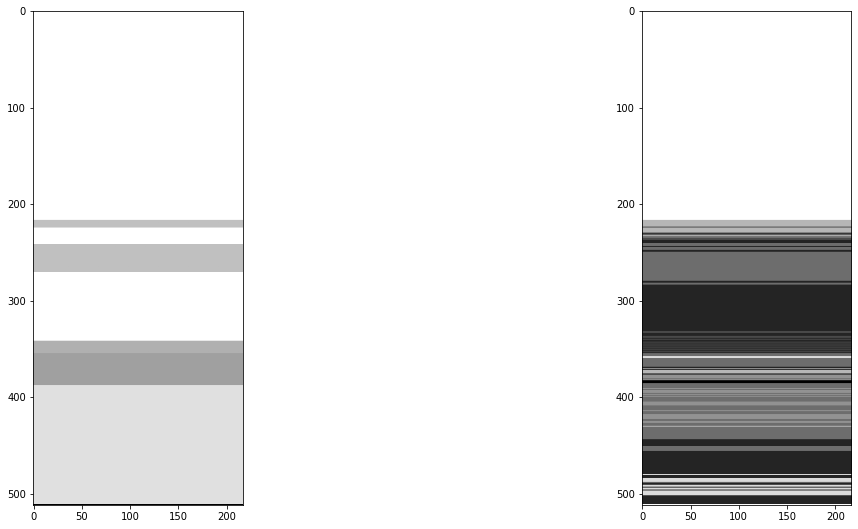

In [ ]:
plot_two_figures(salinas_labels, final_preds, '', '', figsize=(20, 20))

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
adjusted_rand_score(np.array([0,1,1]), np.array(][]))